Reference: https://github.com/twitterdev/do_more_with_twitter_data/blob/master/examples/timeseries/timeseries.ipynb

In [1]:
import datetime
import functools
import itertools
from pathlib import Path
from timeit import default_timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *
from timeseries_utils import *

In [2]:
%matplotlib notebook
plt.style.use("bmh")

pd.options.display.float_format = '{:.2f}'.format

# Timeseries

In [3]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [5]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

In [7]:
campaign_start = min(campaign['tweet_time'])
campaign_end = max(campaign['tweet_time'])
campaign_period = campaign_end - campaign_start

print(campaign_start)
print(campaign_end)
print(campaign_period)

2009-09-06 13:56:00
2020-12-27 18:08:00
4130 days 04:12:00


In [8]:
campaign_years = campaign_period / np.timedelta64(1, "Y")
campaign_years

11.30803507258876

In [9]:
def resample_ts(df, freq):
    return (df
             .set_index('tweet_time')
             .resample(freq)
             .size()
             .reset_index()
             .rename(columns={0:'per_{}_count'.format(freq)})
             .set_index('tweet_time')
            )

<IPython.core.display.Javascript object>


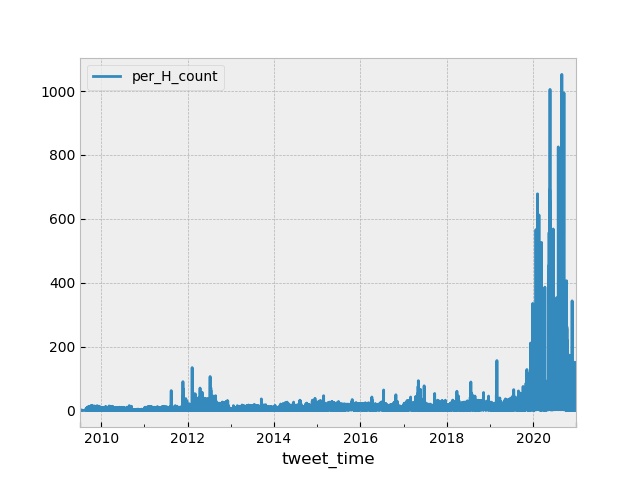

In [10]:
hourly = resample_ts(df, 'H')
hourly.plot()

<IPython.core.display.Javascript object>


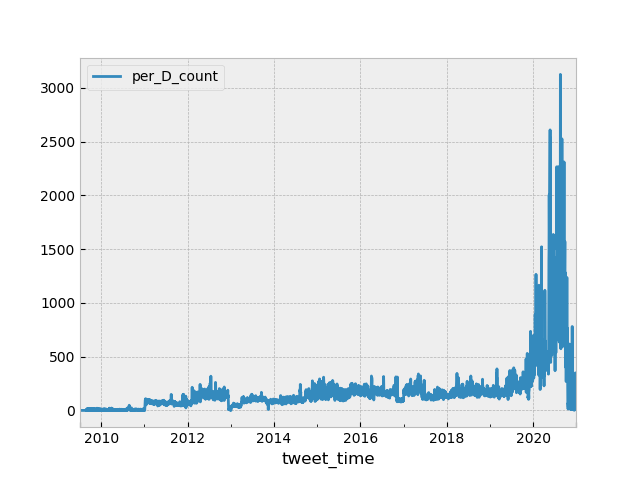

In [11]:
daily = resample_ts(df, 'D')
daily.plot()

In [12]:
print('hourly tweets:\n{}'.format(hourly
                                 .describe()
                                 .astype('int')
                                )
     )

hourly tweets:
       per_H_count
count       100625
mean             7
std             17
min              0
25%              2
50%              4
75%              8
max           1052


<IPython.core.display.Javascript object>


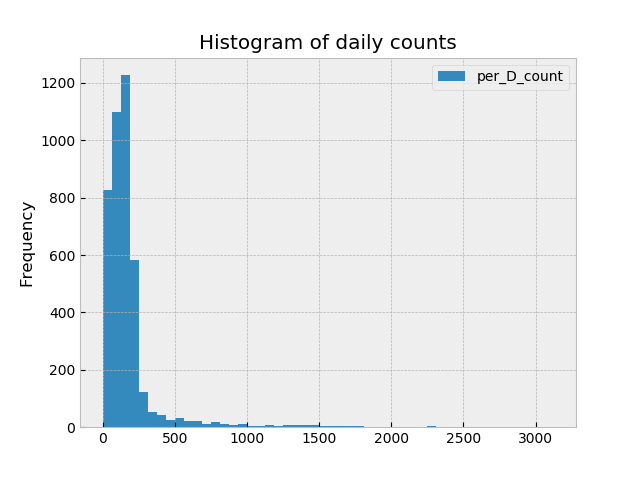

In [14]:
(daily
 .plot.hist(bins=50, title="Histogram of daily counts")
)

The histogram shows that most days had a volume lower than about 250 tweets.

## Differencing

We can use simple differencing to get a sense of the change in tweet volume from day to day during the measured time period.

In [22]:
def standardize(df):
    return (df - df.mean()) / df.std()

In [23]:
daily_diff = (daily
             .diff()
             )
daily_std_diff = (daily
             .pipe(standardize)
             .diff()
            )

In [24]:
print(daily_diff
      .describe()
      .loc[['mean','std','min','max']]
)
print('\nstandardized:\n',
        daily_std_diff
         .describe()
         .loc[['min','max']]
)

      per_D_count
mean         0.01
std        117.46
min      -1980.00
max       1836.00

standardized:
      per_D_count
min        -8.33
max         7.72


<IPython.core.display.Javascript object>


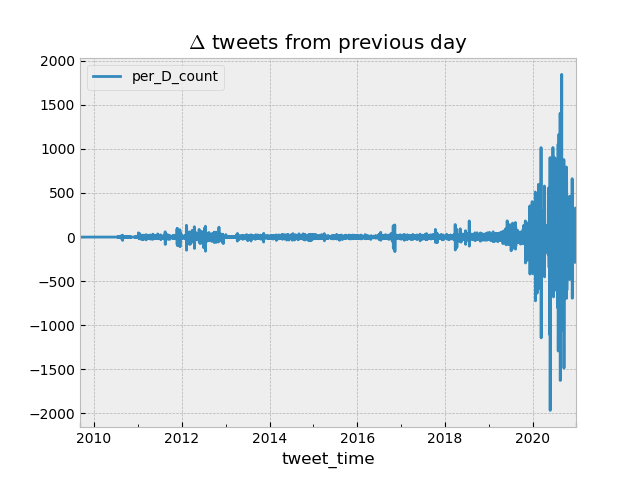

In [21]:
daily_diff.plot(title="$\Delta$ tweets from previous day")

In [23]:
hourly_diff = (hourly
              .diff()
              )

hourly_std_diff = (hourly
                     .pipe(standardize)
                     .diff()
                    )

<IPython.core.display.Javascript object>


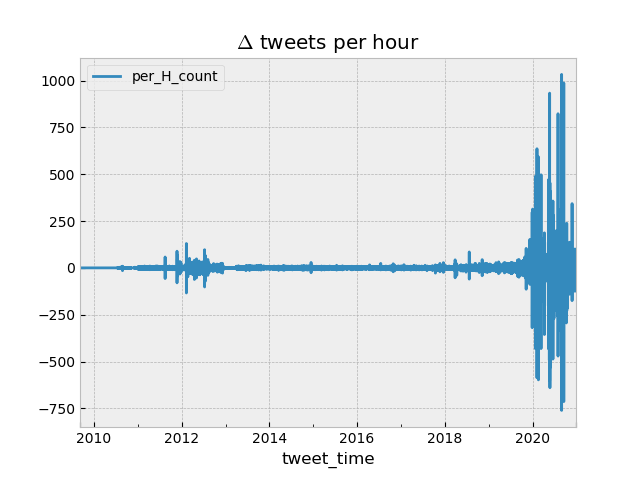

In [24]:
hourly_diff.plot(title="$\Delta$ tweets per hour")

<IPython.core.display.Javascript object>


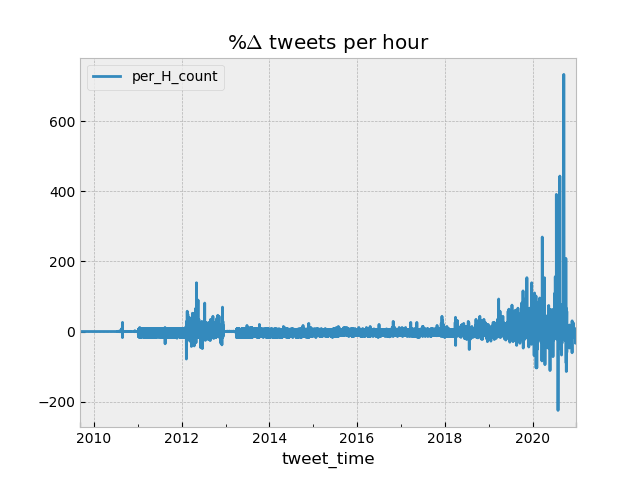

In [25]:
(hourly
 .pipe(standardize)
 .pct_change()
).plot(title="%$\Delta$ tweets per hour")

## Rolling statistics

Rolling statistics can be used to smooth out the signal and show trends more clearly.

<IPython.core.display.Javascript object>


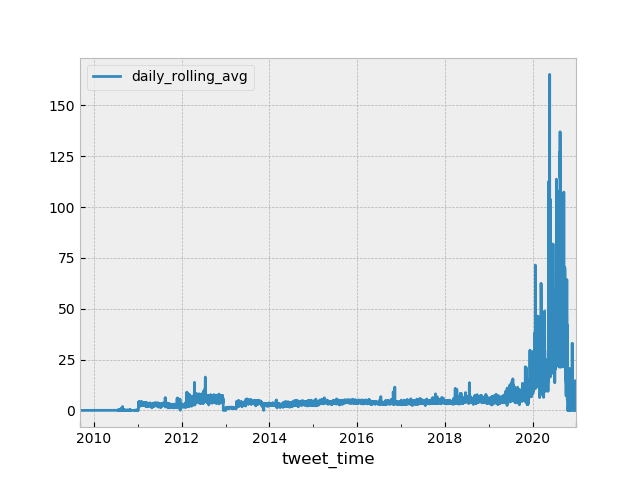

In [51]:
(hourly
 .rolling(24)
 .mean()
 .rename(columns={'per_H_count':'daily_rolling_avg',
                  'tweet_time':'time'})
 .fillna(0)
).plot()

<IPython.core.display.Javascript object>


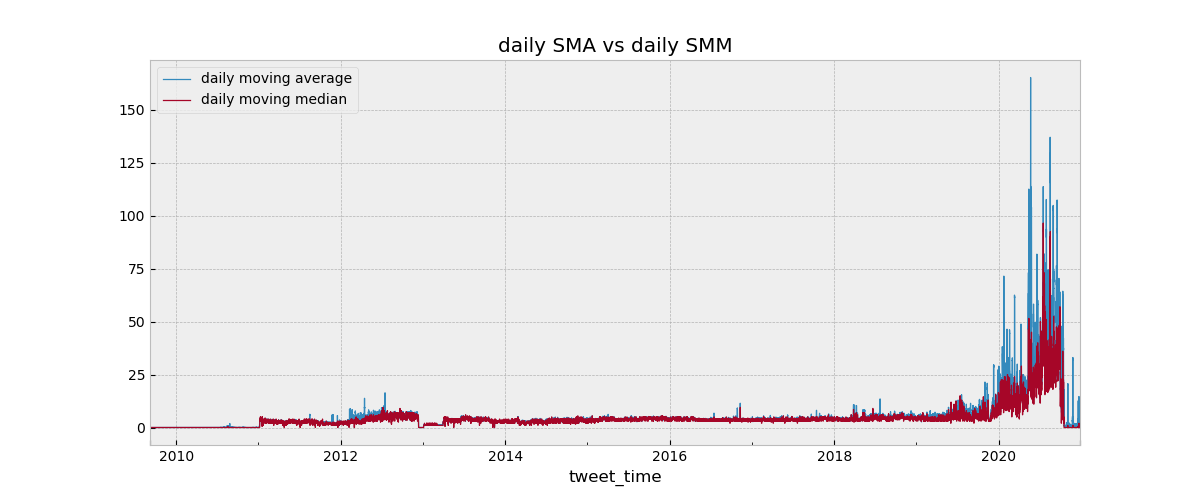

In [49]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24)
 .mean()
 .rename(columns={'per_H_count': 'daily moving average'})
 .plot(ax=axes, lw=0.9));

(hourly
 .rolling(24)
 .median()
 .rename(columns={'per_H_count': 'daily moving median'})
 .plot(ax=axes, lw=0.9));

axes.set_title(label="daily SMA vs daily SMM");

The median is more robust than the mean to outlier values, which also helps us see a smoother signal and more general trend.

<IPython.core.display.Javascript object>


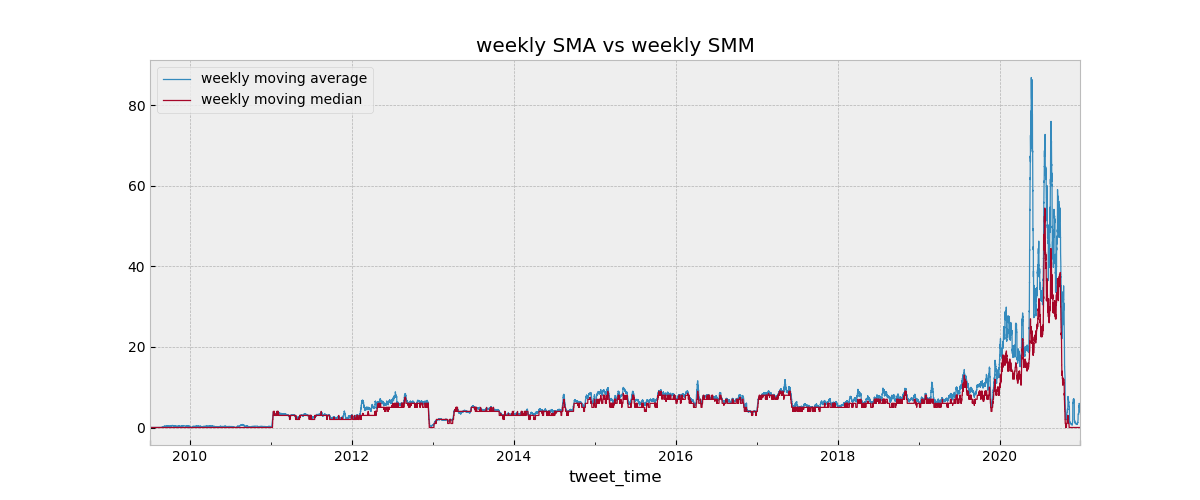

In [25]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24*7)
 .mean()
 .rename(columns={'per_H_count': 'weekly moving average'})
 .plot(ax=axes, lw=0.9));

(hourly
 .rolling(24*7)
 .median()
 .rename(columns={'per_H_count': 'weekly moving median'})
 .plot(ax=axes, lw=0.9));

axes.set_title(label="weekly SMA vs weekly SMM");

<IPython.core.display.Javascript object>


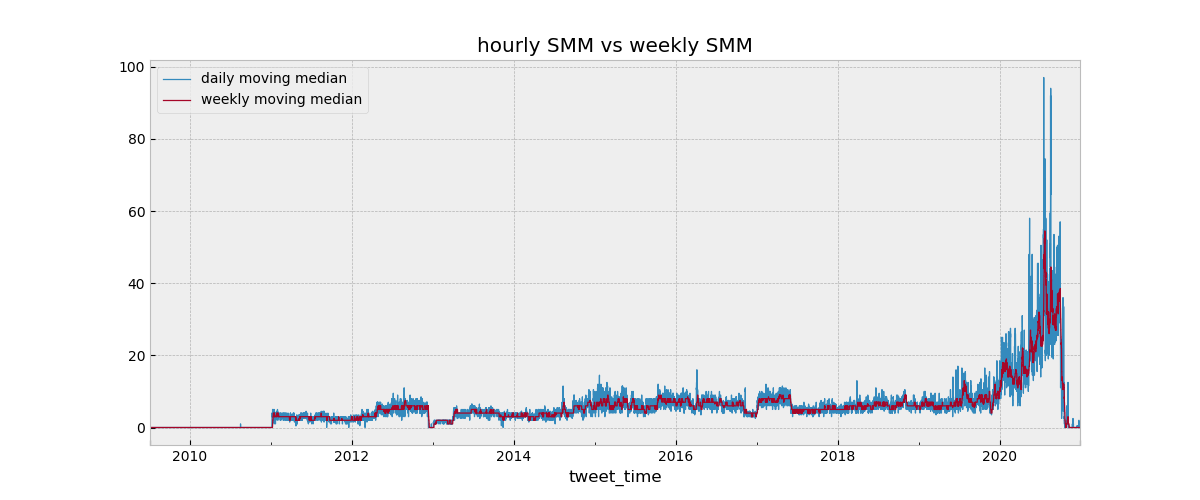

In [26]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24)
 .median()
 .rename(columns={'per_H_count': 'daily moving median'})
 .plot(ax=axes, lw=0.9));

(hourly
 .rolling(24*7)
 .median()
 .rename(columns={'per_H_count': 'weekly moving median'})
 .plot(ax=axes, lw=0.9));

axes.set_title(label="hourly SMM vs weekly SMM");

Here we observe the difference between time periods used for computing the rolling statistic.

## Time period
These initial views show a clear increase in tweet volume after 2019. Further analysis could for instance compare properties of tweets before 2019 with tweets after 2019. It appears that the campaign was more active in the latter period, so separating the two could show the difference between the active component of the campaign, and the earlier low-volumes activity.